# 21BAI1128 Gopal Singh S SLP LAB-9
Write a Python Code to use BERT for Named Entity recognition

dataset: [here](https://www.kaggle.com/datasets/namanj27/ner-dataset/data)

Import Libraries and Set Up Kaggle API for Dataset Download

In [1]:
# Import necessary libraries
import os
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import classification_report
import json
from google.colab import files

# Upload kaggle.json file
uploaded = files.upload()

# Set up Kaggle credentials
with open('kaggle.json', 'r') as f:
    kaggle_creds = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

# Download the dataset
!kaggle datasets download -d namanj27/ner-dataset -p /content
!unzip /content/ner-dataset.zip -d /content


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/namanj27/ner-dataset
License(s): unknown
  0% 0.00/3.17M [00:00<?, ?B/s]
100% 3.17M/3.17M [00:00<00:00, 102MB/s]
Archive:  /content/ner-dataset.zip
  inflating: /content/ner_datasetreference.csv  


Load and Preprocess the Dataset

In [4]:
# Load the dataset
data_path = "/content/ner_datasetreference.csv"
df = pd.read_csv(data_path, encoding='latin1').fillna(method='ffill')
# Display first few rows of the dataset
df.head()


<ipython-input-4-54a568b1dfd4>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_csv(data_path, encoding='latin1').fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


Prepare the Data for BERT Model

In [5]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenize and prepare the dataset for training
def tokenize_and_format_data(df, tokenizer):
    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    labels = df.groupby("Sentence #")["Tag"].apply(list).values

    input_ids, attention_masks, label_ids = [], [], []

    for sentence, label in zip(sentences, labels):
        tokens = tokenizer.encode(sentence, is_split_into_words=True, truncation=True, max_length=128)
        input_ids.append(tokens)
        attention_masks.append([1] * len(tokens))
        label_ids.append([tag2idx.get(tag, tag2idx["O"]) for tag in label])

    return input_ids, attention_masks, label_ids

# Create a mapping for the entity tags to numerical labels
tags = df['Tag'].unique()
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

input_ids, attention_masks, label_ids = tokenize_and_format_data(df, tokenizer)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Split the Data into Training and Testing Sets

In [7]:
from torch.nn.utils.rnn import pad_sequence

# Pad the sequences to the maximum length
def pad_sequences(sequences, max_length=128):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            seq = seq + [0] * (max_length - len(seq))
        else:
            seq = seq[:max_length]
        padded_sequences.append(seq)
    return padded_sequences

# Pad inputs and labels
train_inputs = pad_sequences(train_inputs)
test_inputs = pad_sequences(test_inputs)
train_labels = pad_sequences(train_labels)
test_labels = pad_sequences(test_labels)

# Convert lists to tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)

# Create the DataLoader for training and testing
batch_size = 16

train_dataset = TensorDataset(train_inputs, train_labels)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

test_dataset = TensorDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


Initialize the BERT Model

In [8]:
# Load pre-trained BERT model for token classification
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(tag2idx))

# Set the optimizer
optimizer = AdamW(model.parameters(), lr=3e-5)

# Set the learning rate scheduler
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Train the model

In [11]:
from torch.cuda.amp import GradScaler, autocast

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop setup
train_loss_list = []
scaler = GradScaler()  # for mixed precision training

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Use tqdm to track progress
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        batch_input_ids, batch_labels = batch
        batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            outputs = model(batch_input_ids, labels=batch_labels)
            loss = outputs.loss

        # Backward pass with mixed precision
        scaler.scale(loss).backward()

        # Gradient clipping (optional for stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step using the scaler
        scaler.step(optimizer)
        scaler.update()

        # Scheduler step (if any)
        scheduler.step()

        # Accumulate the loss
        total_loss += loss.item()

    # Compute the average loss over all batches
    avg_loss = total_loss / len(train_dataloader)
    train_loss_list.append(avg_loss)

    # Print the average loss for the epoch
    print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}")


<ipython-input-11-8d364e273169>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # for mixed precision training


Epoch 1:   0%|          | 0/2398 [00:00<?, ?it/s]

<ipython-input-11-8d364e273169>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 - Training Loss: 0.0599


Epoch 2:   0%|          | 0/2398 [00:00<?, ?it/s]

Epoch 2 - Training Loss: 0.0576


Epoch 3:   0%|          | 0/2398 [00:00<?, ?it/s]

Epoch 3 - Training Loss: 0.0569


Evaluate the Model

In [13]:
model.eval()
pred_labels = []  # Initialize empty list for predicted labels
true_labels = []  # Initialize empty list for true labels

# Evaluate the model
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        batch_input_ids, batch_labels = batch
        batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_input_ids)
        logits = outputs.logits

        # Get the predicted labels
        predictions = torch.argmax(logits, dim=-1)

        # Append the predicted and true labels
        pred_labels.extend(predictions.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

# Now `pred_labels` and `true_labels` contain the predictions and true labels respectively


Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

In [14]:
pred_labels_flat = [label for pred in pred_labels for label in pred]
true_labels_flat = [label for true in true_labels for label in true]

# Remove padding labels
filtered_preds = [pred for true, pred in zip(true_labels_flat, pred_labels_flat) if true != -100]
filtered_true = [true for true in true_labels_flat if true != -100]

# Print classification report
print(classification_report(filtered_true, filtered_preds, target_names=tag2idx.keys()))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           O       0.99      1.00      0.99   1195536
       B-geo       0.77      0.40      0.53      7558
       B-gpe       0.79      0.54      0.64      3142
       B-per       0.64      0.57      0.60      3400
       I-geo       0.81      0.21      0.34      1462
       B-org       0.78      0.37      0.50      4151
       I-org       0.73      0.45      0.56      3394
       B-tim       0.77      0.37      0.50      4077
       B-art       0.00      0.00      0.00        94
       I-art       0.00      0.00      0.00        84
       I-per       0.61      0.78      0.68      3406
       I-gpe       0.00      0.00      0.00        33
       I-tim       0.50      0.30      0.37      1251
       B-nat       0.00      0.00      0.00        40
       B-eve       0.00      0.00      0.00        70
       I-eve       0.00      0.00      0.00        65
       I-nat       0.00      0.00      0.00        13

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Plot Training Loss

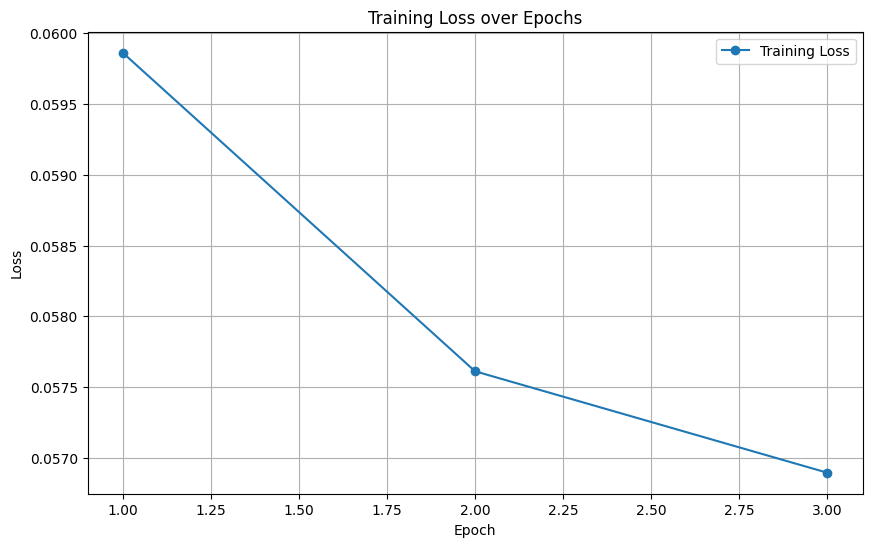

In [15]:
# Plotting Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


Create Word Cloud for Named Entities

In [18]:
# Extract named entities
entity_words = []

for sentence, labels in zip(test_inputs[:len(test_labels)], filtered_preds[:len(test_labels)]):
    # Make sure labels are treated as a sequence, not a single integer
    if isinstance(labels, (int, np.int64)):  # If it's just an int, make it iterable
        labels = [labels]

    for word, label_id in zip(sentence, labels):
        if label_id != tag2idx['O']:
            word = tokenizer.decode([word])
            print(f"Word: {word}, Label: {idx2tag[label_id]}")


# Count occurrences
# Check if entity_counts has any data
if len(entity_counts) > 0:
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entity_counts)

    # Display word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("No entities found to generate a word cloud.")


Word: [CLS], Label: B-per
Word: [CLS], Label: I-per
Word: [CLS], Label: B-org
Word: [CLS], Label: B-gpe
Word: [CLS], Label: B-geo
Word: [CLS], Label: B-per
Word: [CLS], Label: I-per
Word: [CLS], Label: B-gpe
Word: [CLS], Label: B-per
Word: [CLS], Label: I-per
Word: [CLS], Label: I-per
Word: [CLS], Label: B-per
Word: [CLS], Label: B-geo
Word: [CLS], Label: B-geo
Word: [CLS], Label: I-org
Word: [CLS], Label: I-org
Word: [CLS], Label: I-org
Word: [CLS], Label: B-per
Word: [CLS], Label: I-per
Word: [CLS], Label: B-per
Word: [CLS], Label: I-per
Word: [CLS], Label: B-gpe
Word: [CLS], Label: B-tim
Word: [CLS], Label: I-tim
Word: [CLS], Label: B-per
Word: [CLS], Label: I-per
Word: [CLS], Label: B-geo
Word: [CLS], Label: B-per
Word: [CLS], Label: B-per
Word: [CLS], Label: I-per
Word: [CLS], Label: I-per
Word: [CLS], Label: B-gpe
Word: [CLS], Label: B-org
Word: [CLS], Label: I-org
Word: [CLS], Label: B-geo
Word: [CLS], Label: B-per
Word: [CLS], Label: I-per
Word: [CLS], Label: B-geo
Word: [CLS],